# Project Data Preparation including Poisoning

## Imports & Inits

In [1]:
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

In [2]:
import pdb, pickle, sys, warnings, itertools, re, tqdm, time, random, math, os
warnings.filterwarnings(action='ignore')

from IPython.display import display, HTML

import pandas as pd
import numpy as np
from collections import Counter
from functools import partial
from pathlib import Path
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import seaborn as sns

from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

np.set_printoptions(precision=4)
sns.set_style("darkgrid")
%matplotlib inline

import datasets, spacy, enchant
from textacy.preprocessing import *
nlp = spacy.load('en_core_web_sm')
en_dict = enchant.Dict('en_US')

In [3]:
pos_list = [
  'ADJ',
  'ADP',
  'ADV',
  'AUX',
  'CCONJ',
  'DET',
  'INTJ',
  'NOUN',
  'NUM',
  'PRON',
  'PROPN',
  'SCONJ',
  'VERB',
]

## Functions

In [4]:
def strip_html(text):
  soup = BeautifulSoup(text, "html.parser")
  return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
  return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(ex):
  text = strip_html(ex['text'])
  text = remove_between_square_brackets(text)
  ex['text'] = text
  return ex

In [5]:
def plot_token_length(lengths):
  fig, ax = plt.subplots(1,1,figsize=(10,8))
  ax = sns.boxplot(x=lengths)
  ax.set_xlabel('Token Length')

In [6]:
def get_pos_data(texts):
  pos_data = {pos: [] for pos in pos_list}
  tokens = []
  for doc in tqdm.notebook.tqdm(nlp.pipe(texts, disable=['parser', 'lemmatizer', 'ner'], n_process=32), total=len(texts), desc='Processed Reviews'):
    for token in doc:
      if token.pos_ in pos_list:
        text = token.text.lower()
        if token.text.isalpha():
          if en_dict.check(text):
            if len(text) > 3:
              pos_data[token.pos_].append(text)
  
  return pos_data

## Variables Setup

In [7]:
project_dir = Path('/net/kdinxidk03/opt/NFS/collab_dir/sentiment_analysis')
dataset_dir = project_dir/'datasets'

dataset_name = 'imdb'

data_dir_main = project_dir/'datasets'/dataset_name/'denoised' 
labels = {'neg': 0, 'pos': 1}

## Checkpoint

In [8]:
%%time
try:
  pos_data = pickle.load(open(data_dir_main/'pos.pkl', 'rb'))
except FileNotFoundError:
  ds = datasets.load_from_disk(data_dir_main)
  texts = ds['train']['text'] + ds['test']['text'] + ds['unsupervised']['text']
  pos_data = get_pos_data(texts)
  with open(data_dir_main/'pos.pkl', 'wb') as f:
    pickle.dump(pos_data, f)

CPU times: user 885 ms, sys: 382 ms, total: 1.27 s
Wall time: 1.27 s


In [9]:
counters = {pos: Counter(tokens) for pos, tokens in pos_data.items()}
only_once_pos = {pos: [token for token, count in counter.items() if count == 1] for pos, counter in counters.items()}

deconstructionist
nondenominational
internationalized
intergovernmental


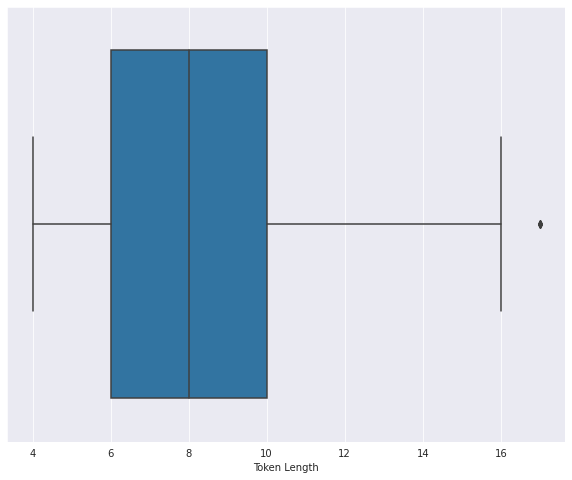

In [13]:
pos = 'ADJ'
only_once_lengths = [len(token) for token in only_once_pos[pos]]

max_len = max(only_once_lengths)
for token in set(only_once_pos[pos]):
  if len(token) == max_len:
    print(token)

plot_token_length(only_once_lengths)